In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')

In [3]:
# Select data
df_predict = df[(df['dt'] >= '1990-01-01')][['dt', 'LandAverageTemperature']].reset_index(drop=True)

In [4]:
df_predict.head()

,dt,LandAverageTemperature
0,1990-01-01,3.243
1,1990-02-01,3.643
2,1990-03-01,6.730
3,1990-04-01,9.169
4,1990-05-01,11.831


what the process for forcasting?
- Data Cleaning
- Time Series Analysis
- Modeling
- Evaluation

# Data Cleaning
---

**Missing Values**

In [5]:
df_predict.isnull().sum()

dt                        0
LandAverageTemperature    0
dtype: int64

In [6]:
# drop missing nulls
df_predict.dropna(inplace=True)

In [7]:
df_predict.isnull().sum()

dt                        0
LandAverageTemperature    0
dtype: int64

**Data Duplicate**

In [8]:
df_predict.duplicated().sum()

0

**Date Time Type**

In [9]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dt                      312 non-null    object 
 1   LandAverageTemperature  312 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [10]:
df_predict["dt"] = pd.to_datetime(df_predict["dt"].str.slice(0, 7), format="%Y-%m")

In [11]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dt                      312 non-null    datetime64[ns]
 1   LandAverageTemperature  312 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB


# Time Series Analysis
---

In [12]:
df_predict_copy = df_predict.copy() 

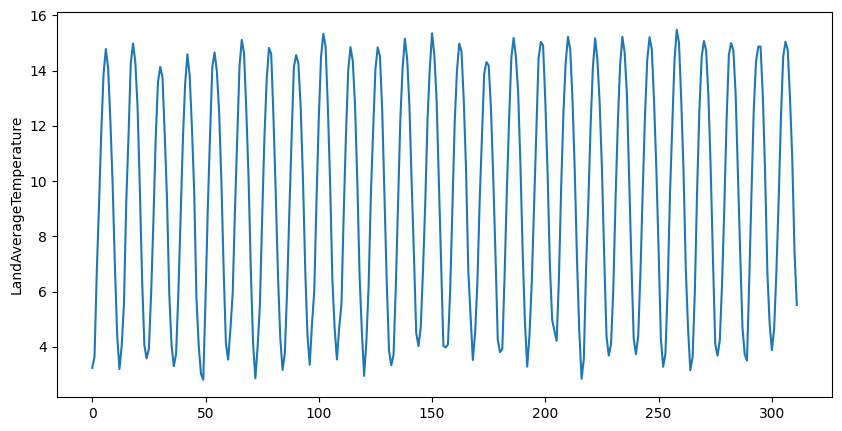

In [13]:
df_predict["LandAverageTemperature"].plot(figsize = (10,5))
plt.ylabel("LandAverageTemperature")
plt.show()

We want to smoothing plot for obtain trend with 2 method:
- Seasonal Decompose
- STL Decompose

## Seasonal Decompose
---

In [14]:
# seasonal decompose 
res = seasonal_decompose(df_predict["LandAverageTemperature"],
                         period = 12) # using 12 because we want to know each months

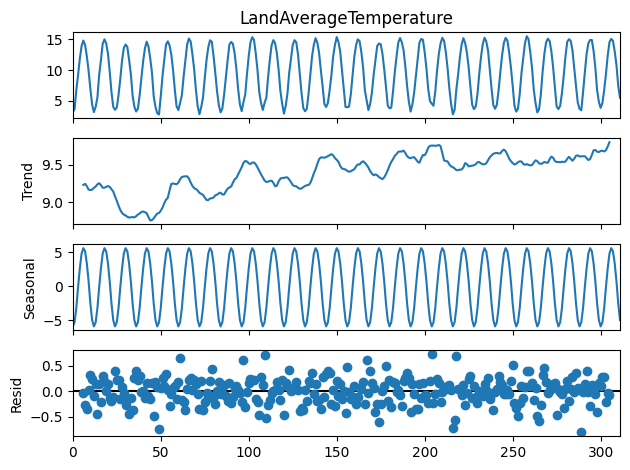

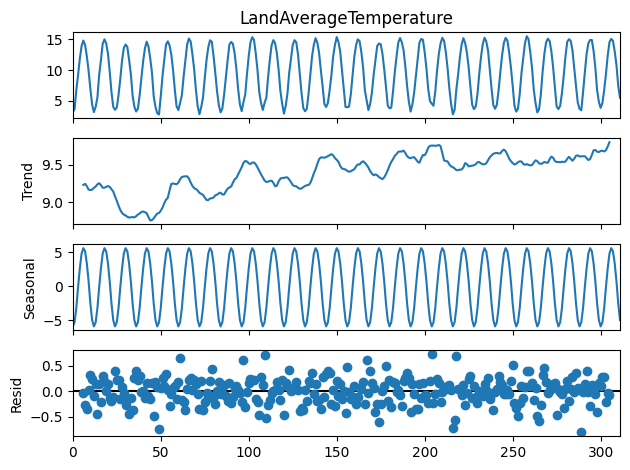

In [15]:
res.plot()

- The model is assumed the data is additive, it means our data is decompose is the addition of trend, seasonal, and residual component.
- Hence, if we add all the components, we will construct our original data.

In [16]:
res_additive = res.trend + res.seasonal + res.resid

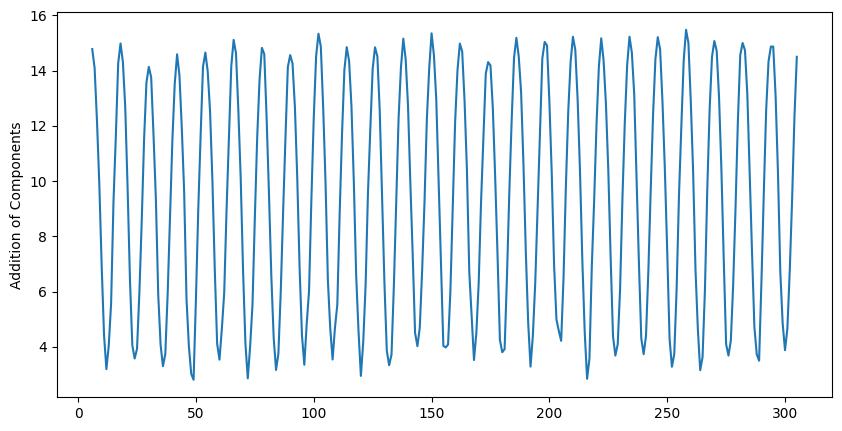

In [17]:
res_additive.plot(figsize = (10,5))
plt.ylabel("Addition of Components")
plt.show()

We obtain that the trend is increasing, but the smoothing line is not far different.

## STL Decompose Loose
---

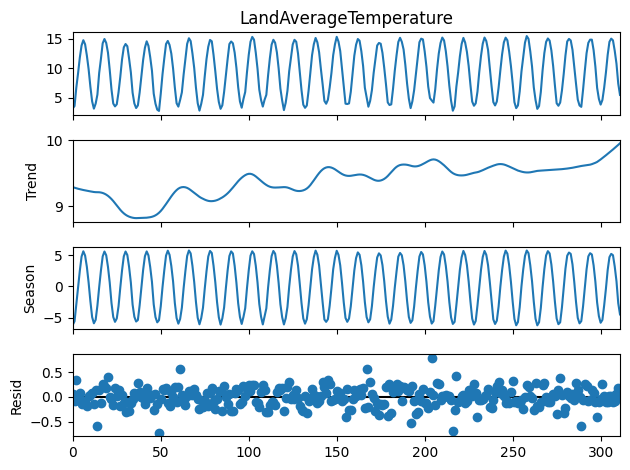

In [18]:
stl = STL(df_predict["LandAverageTemperature"],
          period = 12,
          seasonal = 5)
result = stl.fit()

fig = result.plot()

We obtain that the trend is increasing, but the smoothing line is not far different with seasonal decompose and plot orgin.

We can see that the data is not homoscedastic. We should transform it using some power transformation.

In [19]:
 df_predict_copy = df_predict_copy.groupby("dt").sum()["LandAverageTemperature"] 

In [20]:
df_predict_copy

dt
1990-01-01     3.243
1990-02-01     3.643
1990-03-01     6.730
1990-04-01     9.169
1990-05-01    11.831
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, Length: 312, dtype: float64

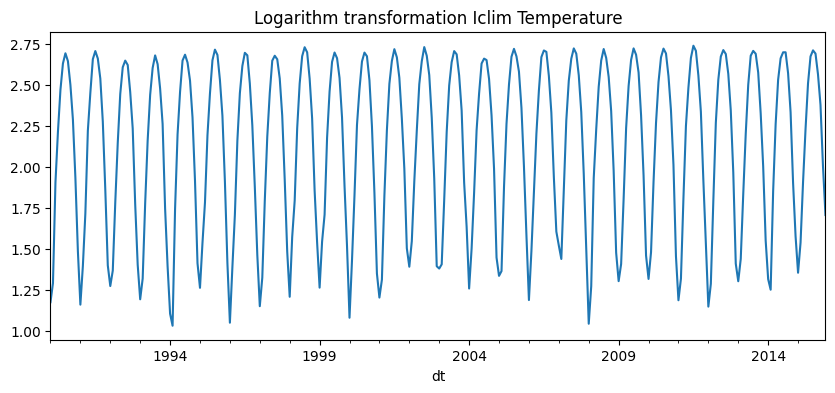

In [21]:
# change to log
df_predict_copy = np.log(df_predict_copy)
df_predict_copy.plot(figsize=(10, 4))

plt.title("Logarithm transformation Iclim Temperature")
plt.show()

Avoiding trend data is knowing with different

In [22]:
# df_predict_copy = df_predict_copy.diff(periods=12)
# df_predict_copy.plot(figsize=(10, 4))

# plt.title("Differencing After Logarithm transformation on Iclim Temperature")

## AutoCorrelation
---

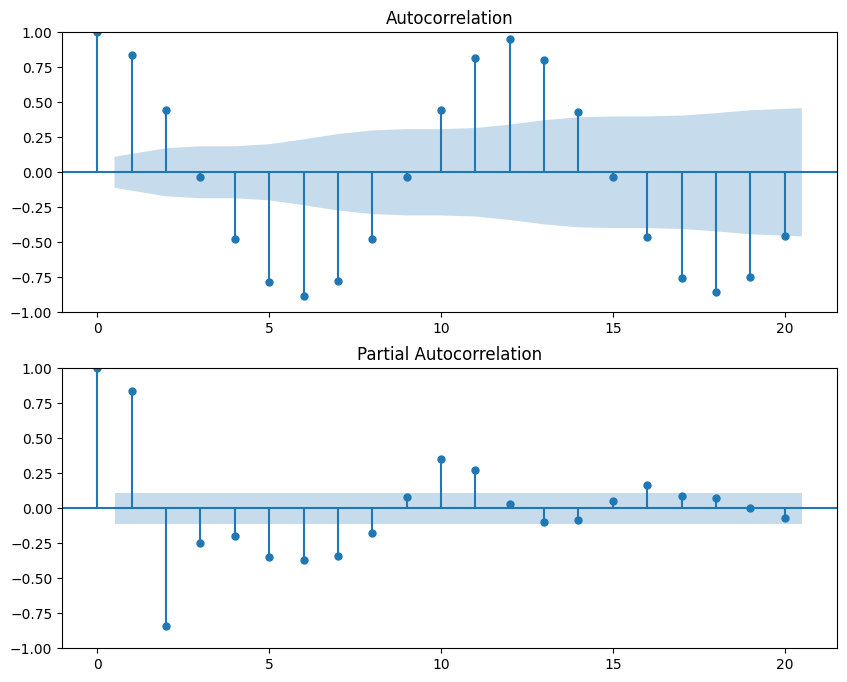

In [23]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_predict_copy, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_predict_copy, lags=20, ax=ax2)

- we obtain the iclim increase slowly and have season each 5
- The PACF shows a strong connection at lag 1, decreases at lag 2, and stays consistent at lag 7. This means that there's a strong positive impact from the previous lag at lag 1, followed by a strong negative impact from lag 2 to lag 3.

# Modeling
---

In [24]:
# infer frequency for modeling
df_predict_copy = df_predict_copy.asfreq(pd.infer_freq(df_predict_copy.index))

# Modeling
arimafit = ARIMA(df_predict_copy, 
                  order = (3, 1, 1), 
                  seasonal_order = (2, 1, 0, 12)).fit()

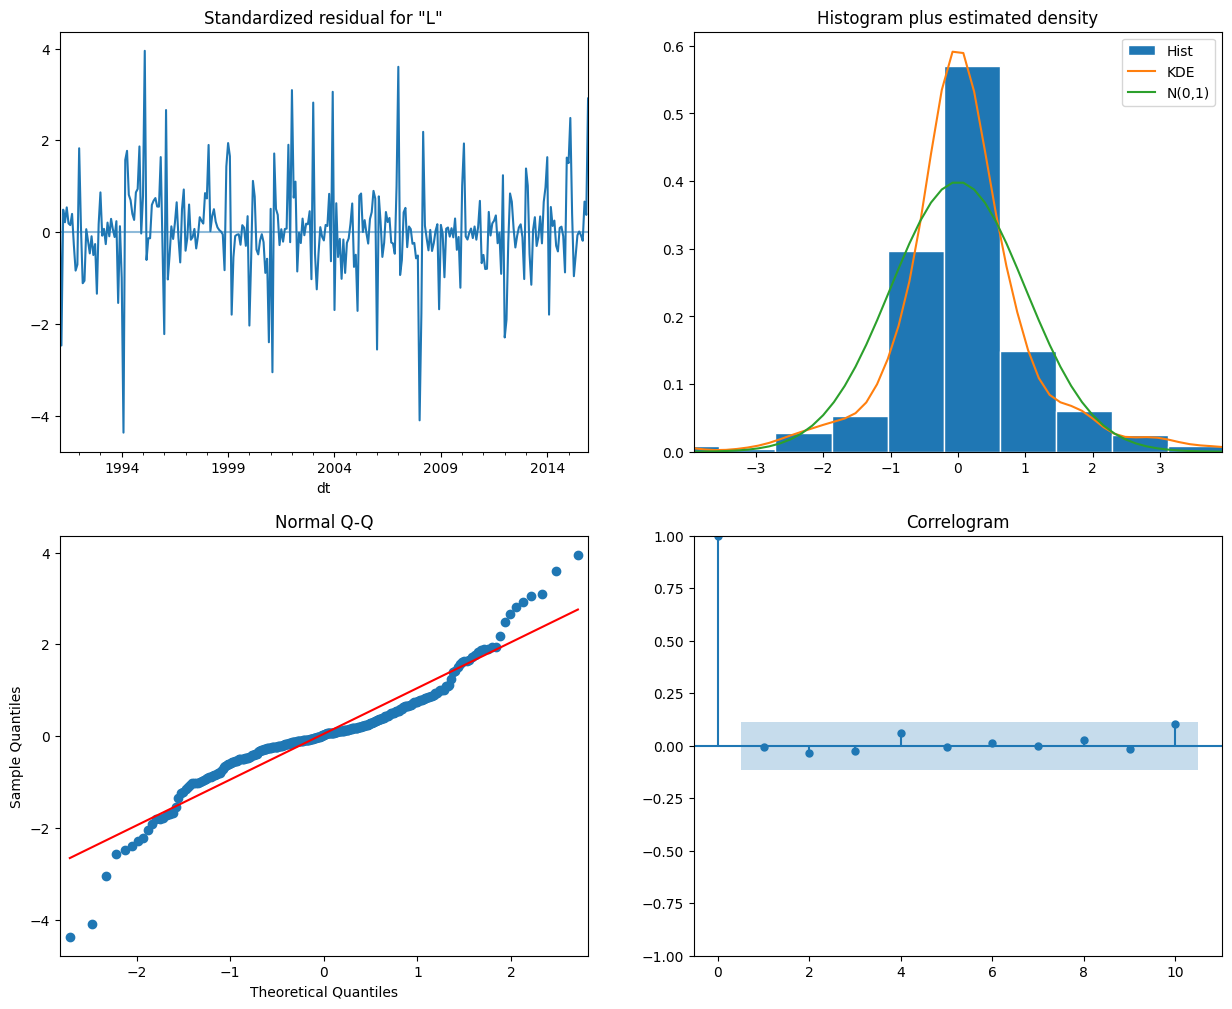

In [25]:
arimafit.plot_diagnostics(figsize=(15, 12))
plt.show()

From plot plot diagnostics, we obtain stationer data, which is good for this

## Splitting Data
---

In [26]:
ts_split = TimeSeriesSplit(n_splits=2)

# Memisahkan data menjadi train dan test menggunakan TimeSeriesSplit
for train_index, test_index in ts_split.split(df_predict_copy):
    train_ts = df_predict_copy.iloc[train_index]
    test_ts = df_predict_copy.iloc[test_index]

In [27]:
# copy data train and test
train_ts_copy = train_ts.copy
test_ts_copy = test_ts.copy

In [28]:
train_ts.shape

(208,)

In [29]:
test_ts.shape

(104,)

In [30]:
model_orders = [
    ((3, 1, 1), (2, 1, 0, 12)),
    ((3, 1, 0), (2, 1, 0, 12)),
    ((3, 1, 0), (3, 1, 0, 12)),
    ((3, 1, 1), (0, 1, 2, 12)),
    ((3, 1, 3), (0, 1, 1, 12))
]

In [31]:
# Initialize lists to store AIC values and corresponding SARIMA parameters
aic = []
pdq_list = []
pdq_seasonal_list = []

# Loop through each combination of (p, d, q) and (P, D, Q, s) parameters
for (pdq, seasonal_pdq) in model_orders:
    # Fit SARIMA model using ARIMA for each combination of parameters
    sarima_model = ARIMA(train_ts,
                         order=pdq,
                         seasonal_order=seasonal_pdq,
                         enforce_stationarity=False)
                         
    results = sarima_model.fit()
    
    # Append SARIMA parameters and AIC to lists
    pdq_list.append(pdq)
    pdq_seasonal_list.append(seasonal_pdq)
    aic.append(results.aic)
    
    # Print AIC values for each SARIMA model
    print('ARIMA{}x{}12 - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

ARIMA(3, 1, 1)x(2, 1, 0, 12)12 - AIC:-412.1410497577527
ARIMA(3, 1, 0)x(2, 1, 0, 12)12 - AIC:-399.4428439623504
ARIMA(3, 1, 0)x(3, 1, 0, 12)12 - AIC:-405.8400093233921
ARIMA(3, 1, 1)x(0, 1, 2, 12)12 - AIC:-436.95648229961165
ARIMA(3, 1, 3)x(0, 1, 1, 12)12 - AIC:-467.75151262094585


In [32]:
aic_models_csales = pd.DataFrame({"pdq": pdq_list,
                           "pdq_seasonal": pdq_seasonal_list,
                           "AIC": aic})

aic_models_csales

,pdq,pdq_seasonal,AIC
0,"(3, 1, 1)","(2, 1, 0, 12)",-412.141050
1,"(3, 1, 0)","(2, 1, 0, 12)",-399.442844
2,"(3, 1, 0)","(3, 1, 0, 12)",-405.840009
3,"(3, 1, 1)","(0, 1, 2, 12)",-436.956482
4,"(3, 1, 3)","(0, 1, 1, 12)",-467.751513


In [33]:
best_aic_csales = aic_models_csales.loc[aic_models_csales["AIC"].argmin()]

In [34]:
best_aic_csales

pdq                 (3, 1, 3)
pdq_seasonal    (0, 1, 1, 12)
AIC               -467.751513
Name: 4, dtype: object

In [35]:
sarima_model = ARIMA(train_ts, 
                     order = best_aic_csales["pdq"],
                     seasonal_order = best_aic_csales["pdq_seasonal"],
                     enforce_stationarity = False,
                     enforce_invertibility = False).fit()

print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:             LandAverageTemperature   No. Observations:                  208
Model:             ARIMA(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 242.514
Date:                            Fri, 12 Apr 2024   AIC                           -469.028
Time:                                    11:16:24   BIC                           -443.529
Sample:                                01-01-1990   HQIC                          -458.688
                                     - 04-01-2007                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1142      0.521     -0.219      0.827      -1.136       0.907
ar.L2          0.4142      0.529   

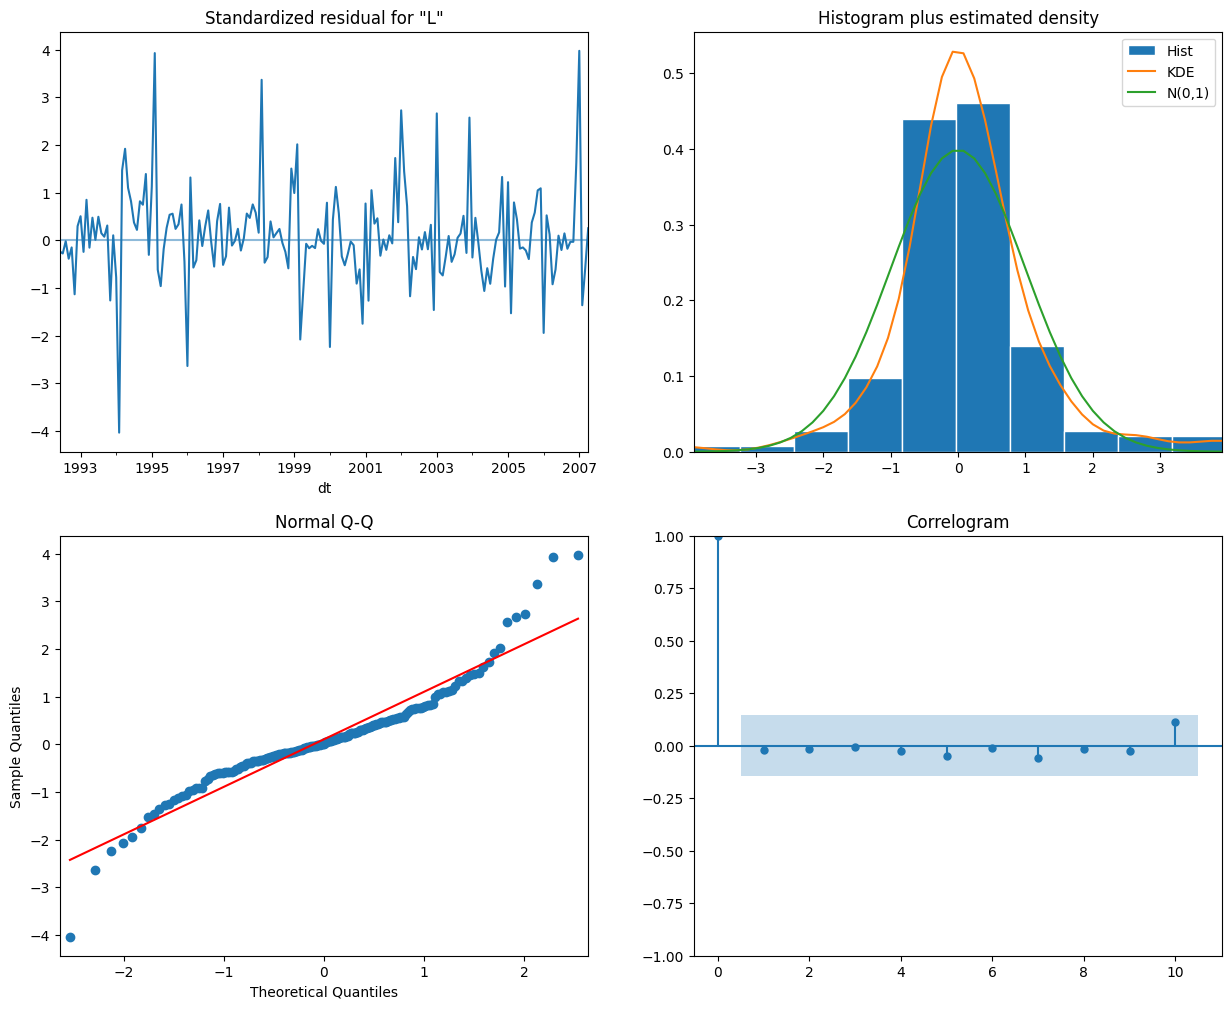

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
rsme_test = np.sqrt(mse(test_ts, sarima_model.forecast(steps=104)))

In [38]:
rsme_test

0.0712245692341419

## Time Series Cross Validation For ARIMA
---

In [39]:
def cross_validate_arima(X, od_arima, seasonal_od_arima, n_fold = 5, test_size = None, gap = 0):
    """
    Function to evaluate RMSE by time series cross-validation.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    od_arima : {array-like} 
        The order of arima (p, d, q)

    seasonal_od_arima : {array-like} 
        The seasonal order of arima (P, D, Q)
        
    n_fold : int
        Number of n_split for TimeSeriesSplit.
        
    test_sizes : int
        Number of test_sizes for TimeSeriesSplit.
        
    gap : int
        Number of gap for TimeSeriesSplit.

    Returns
    -------
    score : float
        The average RMSE score.
    """
    
    # Placeholder for index 
    train_ind_list = []
    valid_ind_list = []
    
    # Define TS Split
    tscv = TimeSeriesSplit(n_splits = n_fold, 
                           test_size = test_size, 
                           gap = gap)
    
    # Get train and valid test index
    for i, (train_index, val_index) in enumerate(tscv.split(X)):
        train_ind_list.append(train_index)
        valid_ind_list.append(val_index)
        
    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize RMSE score list for each valid and train set
    score_list_valid = []
    score_list_train = []    
    pred_train = []    
    pred_valid = []    

    for i in range(n_split):
        
        # Extract data from index
        X_train = X.iloc[train_ind_list[i]]
        X_valid = X.iloc[valid_ind_list[i]]

        # Fitting model
        model_arima = ARIMA(X_train, 
                     order = od_arima,
                     seasonal_order = seasonal_od_arima,
                     enforce_stationarity = False,
                     enforce_invertibility = False).fit()

        # Get fitted values
        
        start_date = X_valid.index[0]
        end_date = X_valid.index[-1]
        
        X_pred_train = model_arima.fittedvalues
        X_pred_valid = model_arima.predict(start = start_date, 
                                           end = end_date)

        # Calculate RMSE
        rmse_train = np.sqrt(mean_squared_error(y_true = X_train, 
                                                y_pred = X_pred_train))
        
        rmse_valid = np.sqrt(mean_squared_error(y_true = X_valid, 
                                                y_pred = X_pred_valid))

        # Append RMSE score in list
        score_list_valid.append(rmse_valid)
        # append RMSE score in list
        score_list_train.append(rmse_train)
        
        
        # Append RMSE score in list
        pred_train.append(X_pred_train)
        # append RMSE score in list
        pred_valid.append(X_pred_valid)
        
        
    # Calculate CV Score
    score_list = pd.DataFrame({"RMSE_train": score_list_train,
                               "RMSE_valid": score_list_valid})
    score_valid = np.mean(score_list_valid)

    return (train_ind_list, 
            valid_ind_list, 
            pred_train,
            pred_valid,
            score_valid, 
            score_list)

## Configure CV using number of folds
---

In [40]:
# Check the CV function
train_ind_list, valid_ind_list, \
X_pred_train, X_pred_valid, \
validation_set_score, score_folds = cross_validate_arima(X = train_ts,
                                                         n_fold = 5,
                                                         od_arima = (3,1,3),
                                                         seasonal_od_arima = (0,1,1,12))

/home/work/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [41]:
# Check the CV function
train_ind_list, valid_ind_list, \
X_pred_train, X_pred_valid, \
validation_set_score, score_folds = cross_validate_arima(X = train_ts,
                                                         n_fold = 5,
                                                         test_size = 20,
                                                         od_arima = (3,1,3),
                                                         seasonal_od_arima = (0,1,1,12))

In [42]:
n_split = len(train_ind_list)
x_train_list = []
x_valid_list = []

for i in range(n_split):        
        x_train_list.append(train_ts.iloc[train_ind_list[i]])
        x_valid_list.append(train_ts.iloc[valid_ind_list[i]])

In [43]:
# Check the first fold of training set
x_train_list[0].shape

(108,)

In [44]:
# Check the first fold of testing set
x_valid_list[0].shape

(20,)

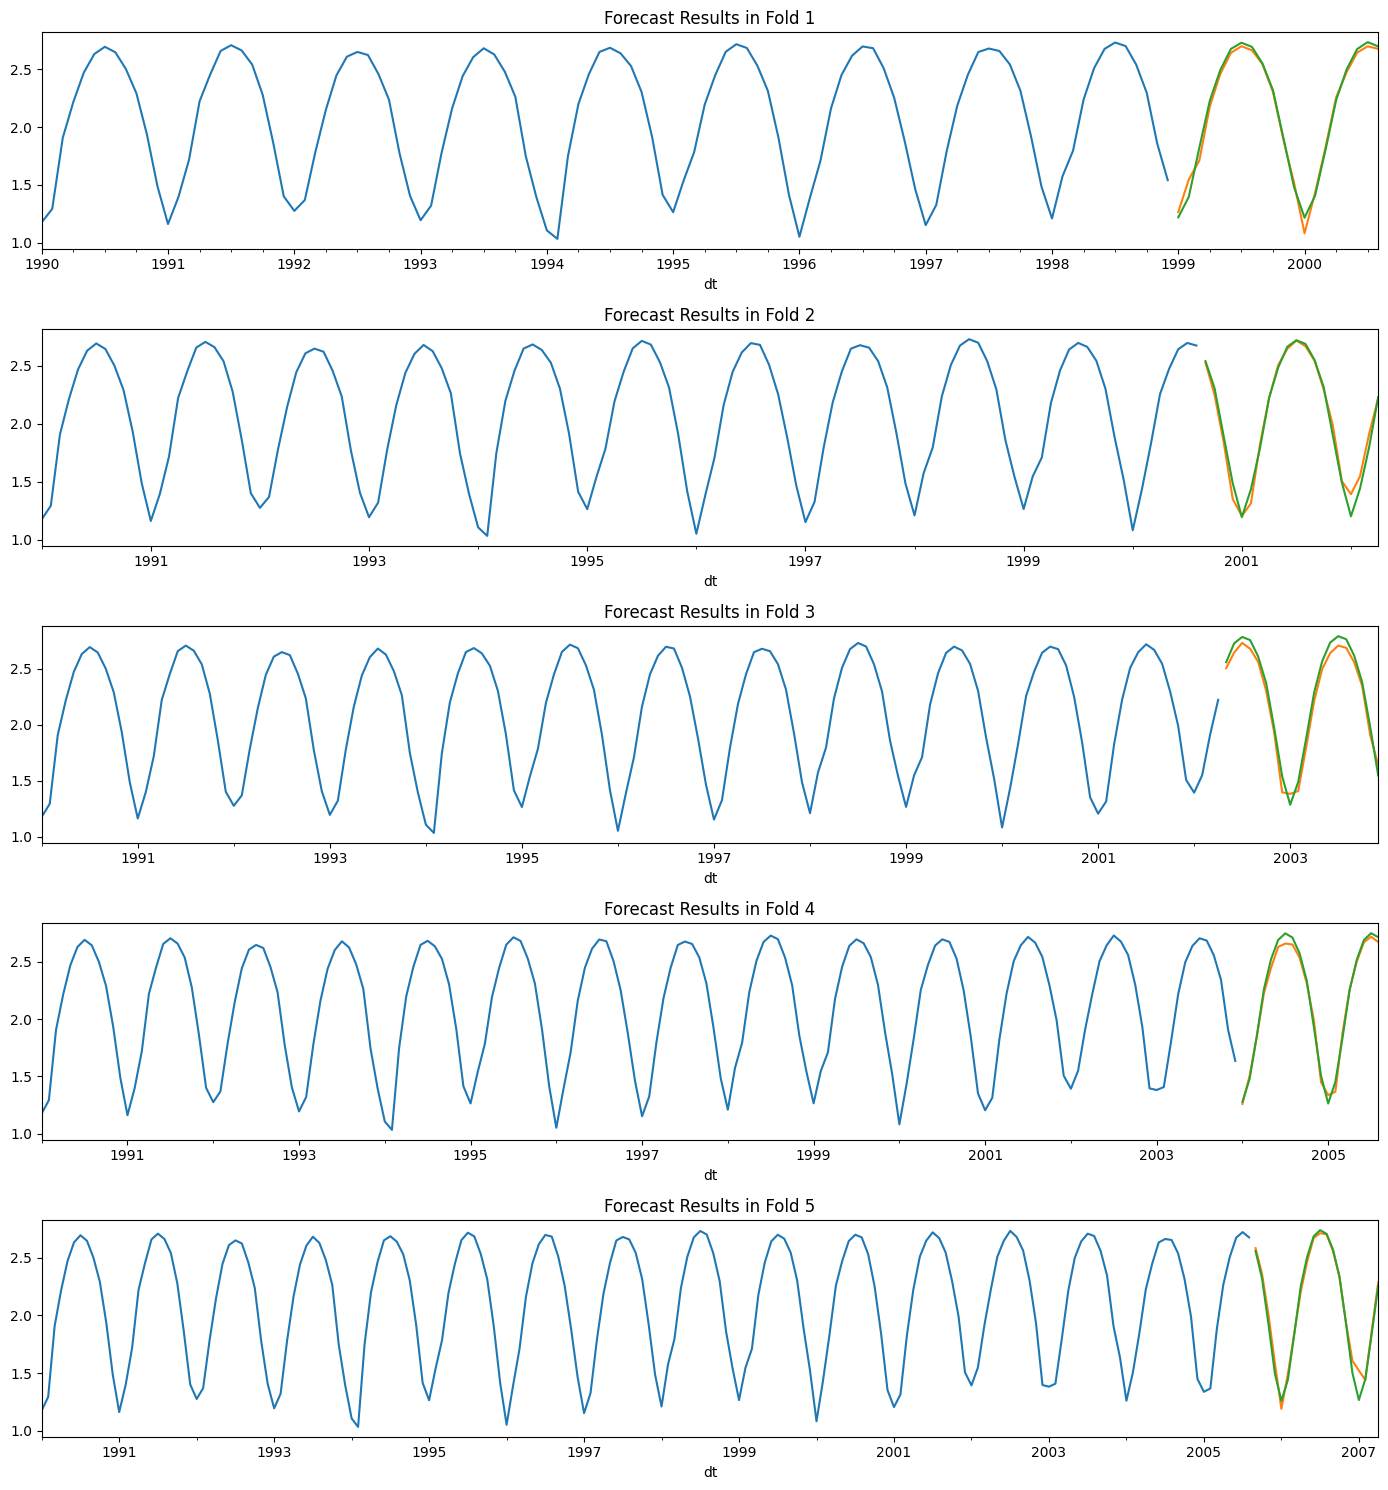

In [45]:
fig, axes = plt.subplots(len(x_train_list),1,
                        figsize=(14, 15))

for i in range(n_split):
    x_train_list[i].plot(ax = axes[i], label = "train", legend = False)
    x_valid_list[i].plot(ax = axes[i], label = "valid", legend = False)
    X_pred_valid[i].plot(ax = axes[i], label = "prediction", legend = False)
    
    axes[i].set_title(f"Forecast Results in Fold {i+1}")

plt.tight_layout()
plt.show()

# Summarize Evaluation
---

In [46]:
fold_rsme = []
for i in range(1, len(x_valid_list)):
    fold_rsme.append(np.sqrt(mean_squared_error(x_valid_list[i], X_pred_valid[i])))

In [47]:
fold_rsme

[0.07438753878932548,
 0.07766764491683864,
 0.05017021683135776,
 0.0733236468965794]

In [48]:
folds_rmse = pd.DataFrame({"Fold": [i+1 for i in range(len(fold_rsme))],
                           "RMSE": [fold_rsme[i] for i in range(len(fold_rsme))]})

In [49]:
summary_score = pd.DataFrame({"Evaluation": ["Cross Validation",
                                             "Train Test Split"],
                              "RMSE": [np.mean(fold_rsme),
                                       rsme_test]})

In [50]:
folds_rmse

,Fold,RMSE
0,1,0.074388
1,2,0.077668
2,3,0.050170
3,4,0.073324


In [51]:
summary_score

,Evaluation,RMSE
0,Cross Validation,0.068887
1,Train Test Split,0.071225


What if we compare with the naive model (Baseline)? 

In [52]:
# set the forecast is the last season value
naive_forecast = df_predict['LandAverageTemperature'].shift(1).fillna(0)

In [53]:
rmse_naive = np.sqrt(mse(df_predict["LandAverageTemperature"], naive_forecast))
rmse_naive

2.1669874190587666

Good model!

# Forecasting with Best Model
---

In [54]:
sarima_model.forecast(steps = 12)

2007-05-01    2.526824
2007-06-01    2.699378
2007-07-01    2.750110
2007-08-01    2.717624
2007-09-01    2.584375
2007-10-01    2.349636
2007-11-01    1.957963
2007-12-01    1.534350
2008-01-01    1.306325
2008-02-01    1.466368
2008-03-01    1.859894
2008-04-01    2.265372
Freq: MS, Name: predicted_mean, dtype: float64

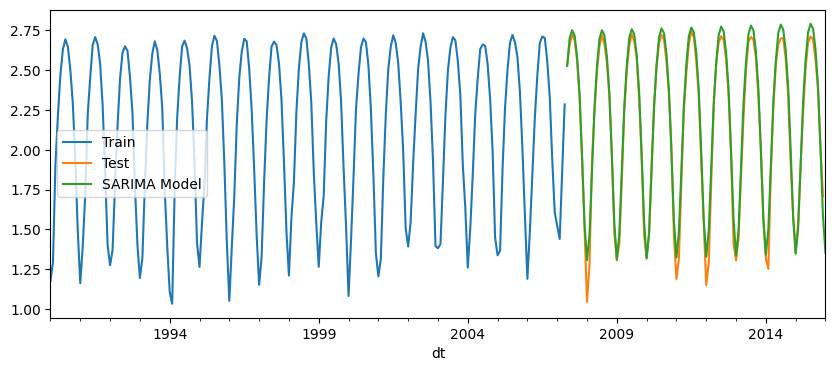

In [55]:
# Plot actual values of train and test data
train_ts.plot(figsize = (10,4), legend = True, label = "Train")
test_ts.plot(figsize = (10,4), legend = True, label = "Test")

# Plot forecast results
sarima_model.forecast(steps = 105).plot(label = "SARIMA Model", legend = True)

plt.show()

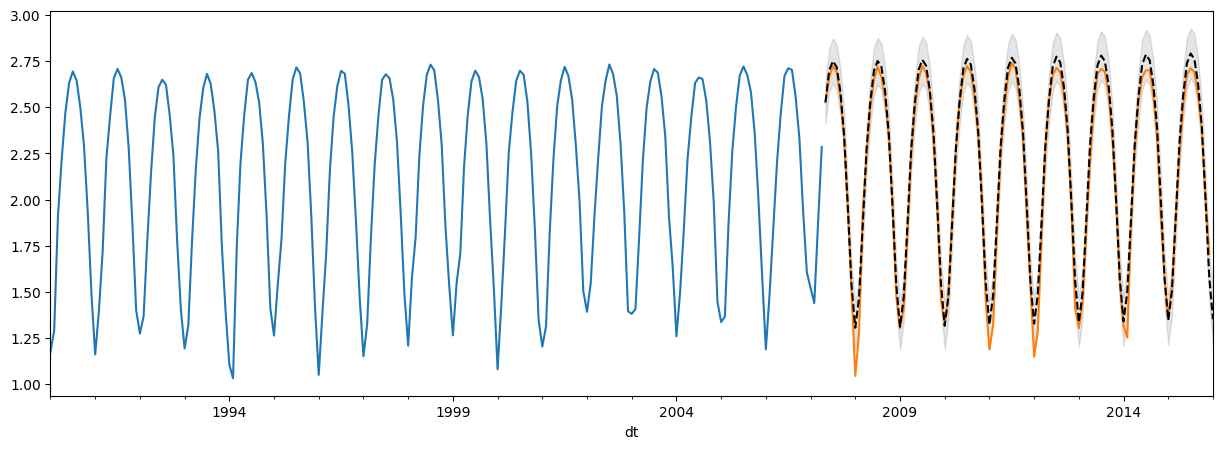

In [56]:
# Construct the forecasts and the prediction interval
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
train_ts.plot(ax = ax)
test_ts.plot(ax = ax)

# Plot the forecast
fcast = sarima_model.get_forecast(steps = 105).summary_frame()
fcast['mean'].plot(ax = ax, style='k--')

# Plot the conf interval
ax.fill_between(fcast.index, 
                fcast['mean_ci_lower'], 
                fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.show()